This work is from the Week 5 Lecture.

In [1]:
from tensorflow.keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words = 10000)

print(train_labels[0])
# train_data[0] # ! Very long array.

1


Part of the preprocessing here consists of one-hot encoding.

When the dataset was loaded, ``num_words`` was set to 10k. This finds the 10k most commonly occurring words, changing the word itself to the placement (e.g "bad" could be 47th most common, so "bad" becomes 47). Then, we iterate through every single row to find the words in each review. Because the neural network can't accept 47 as a number, we instead make a matrix of all 0s, and set the 47th 0 to 1. This is done for every one of the 10000 words so a vectorised row would look like "0,0,1,0,0,0,0,1,1,1,0" etc.

In [2]:
import numpy as np

# ! A 'sequence' refers to a review in this context.
def vectorize_sequences(sequences, dimension = 10000):
    # ? First creates a 10000-long matrix of just 0s.
    results = np.zeros((len(sequences), dimension))
    
    # ? For each ranked word of the review, change the relevant 0 in the matrix to a 1.
    # ? e.g if "bad" is 47, make column 47 into 1.
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1. 
        # ? The . after 1 means it's a float, not an int.
        # ? This is seen often, though is fundamentally identical to "1.0", which is easier to read.
        # ? Leaving it here as a reminder in case it reappears.
        
    return results

# ? Vectorise the training and testing sets.
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

# ? Convert the labels to np arrays.
# ! Is this actually necessary?
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

# ! The model's validation loss is extremely high. Dropout reduces it significantly, 
# ! though I'm not sure at what cost yet.
DROPOUT = 0.6

model = models.Sequential()

# ! You COULD do:
# model.add(layers.Input(shape=(10000,))) 

# ! But instead of that you can do:
model.add(layers.Dense(16, activation = "relu", input_shape = (10000,)))
# ! which seems to be identical. Seems to infer that it's the input layer from input_shape.

model.add(layers.Dropout(DROPOUT))
model.add(layers.Dense(16, activation = "relu"))
model.add(layers.Dropout(DROPOUT))
model.add(layers.Dense(1, activation = "sigmoid")) # 1 class (binary) so 1 output.

model.compile(optimizer = optimizers.Adam(learning_rate = 0.001), 
              # ? Binary classification so binary crossentropy.
              loss = "binary_crossentropy", 
              metrics = ["accuracy"])

In [107]:

x_val = x_train[:10000] # ? Everything up to row 10000.
partial_x_train = x_train[10000:] # ? Everything past row 10000.
y_val = y_train[:10000]
partial_y_train = y_train[10000:]


# ! Isn't this backwards? Why is the validation set twice the size of the training?

In [108]:

# ? Be careful how many times you run this cell. Previous models don't seem to be cleared from RAM.
# ? If progress drastically slows, restart the kernel.

history = model.fit(partial_x_train, partial_y_train,
                    epochs = 8,
                    batch_size = 512,
                    validation_data = (x_val, y_val))

# ! Although the epochs progression bar reads 1/30, that is correct. It's splitting into 30 batches of 512.
# ! Batch size is what you're dividing the full set by to then determine the size of each.


Epoch 1/8
30/30 [==============================] - 1s 28ms/step - loss: 0.6701 - accuracy: 0.5728 - val_loss: 0.6166 - val_accuracy: 0.7957
Epoch 2/8
30/30 [==============================] - 1s 20ms/step - loss: 0.5780 - accuracy: 0.6979 - val_loss: 0.4676 - val_accuracy: 0.8517
Epoch 3/8
30/30 [==============================] - 1s 18ms/step - loss: 0.4812 - accuracy: 0.7704 - val_loss: 0.3675 - val_accuracy: 0.8768
Epoch 4/8
30/30 [==============================] - 1s 17ms/step - loss: 0.4074 - accuracy: 0.8253 - val_loss: 0.3121 - val_accuracy: 0.8860
Epoch 5/8
30/30 [==============================] - 1s 24ms/step - loss: 0.3523 - accuracy: 0.8516 - val_loss: 0.2869 - val_accuracy: 0.8883
Epoch 6/8
30/30 [==============================] - 0s 17ms/step - loss: 0.3051 - accuracy: 0.8825 - val_loss: 0.2722 - val_accuracy: 0.8905
Epoch 7/8
30/30 [==============================] - 1s 18ms/step - loss: 0.2704 - accuracy: 0.8958 - val_loss: 0.2712 - val_accuracy: 0.8905
Epoch 8/8
30/30 [===

782/782 [==============================] - 2s 2ms/step - loss: 0.2924 - accuracy: 0.8827


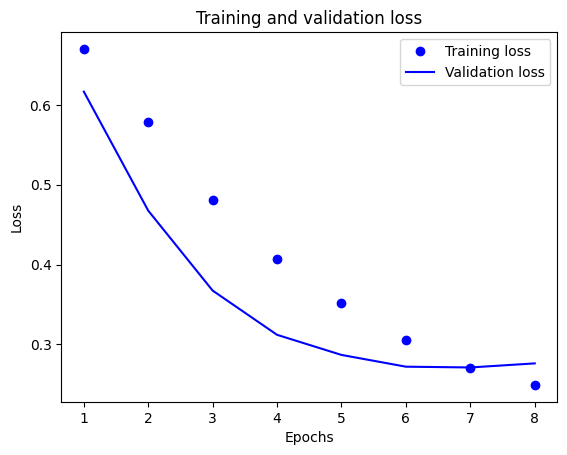

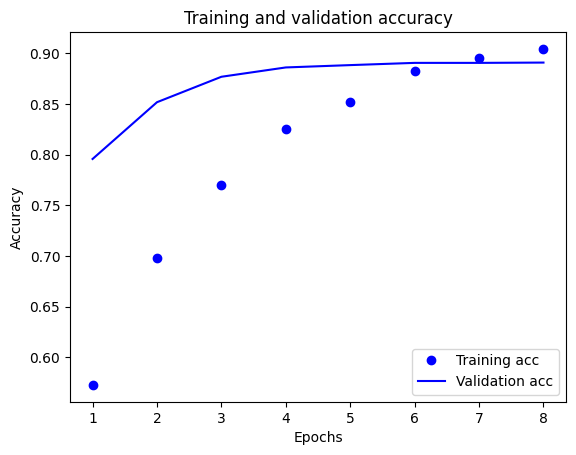

In [109]:
import matplotlib.pyplot as plt 

history_dict = history.history
results = model.evaluate(x_test, y_test)

# print(f"Score (lower is better): {results[0]}\nAccuracy (higher is better): {results[1]}")

loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.clf() # ? Useful one to remember. Clears the current figure so you could do multiple plots from one cell.

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()